<div style="background-color:white;" >
<div style="clear: both; display: table;">
  <div style="float: left; width: 14%; padding: 5px; height:auto">
    <img src="img/TUBraunschweig_CO_200vH_300dpi.jpg" alt="TU_Braunschweig" style="width:100%">
  </div>
  <div style="float: left; width: 28%; padding: 5px; height:auto">
    <img src="img/TU_Clausthal_Logo.png" alt="TU_Clausthal" style="width:100%">
  </div>
  <div style="float: left; width: 25%; padding: 5px; height:auto">
    <img src="img/ostfalia.jpg" alt="Ostfalia" style="width:100%">
  </div>
  <div style="float: left; width: 21%; padding: 5px;">
    <img src="img/niedersachsen_rgb_whitebg.png" alt="Niedersachsen" style="width:100%">
  </div>
  <div style="float: left; width: 9%; padding: 5px;">
    <img src="img/internet_BMBF_gefoerdert_2017_en.jpg" alt="bmbf" style="width:100%">
  </div>
</div>
<div style="text-align:center">
<img src="img/ki4all.jpg" alt="KI4ALL-Logo" width="200"/>
</div>
</div>

# Synthetic Biomedical Data – Lesson 3: Advanced Data Generation
Part of the *Microcredit Artificial Data Generator* module.

➡️ [Back to Lesson 2: Data Generation Basics](01_intro.ipynb)
➡️ [Module README](../README.md)

*Before continuing, please ensure you reviewed the prerequisites and learning goals in Lesson 1.*


# Synthetic Biomedical Data — 03b: Irrelevant Features (Correlations, Pseudo & Robustness)

**Goal.** Move beyond independent noise. We introduce **correlated feature blocks** (`CorrCluster`)
and **pseudo** (redundant/derived) features. We contrast model robustness and briefly explore how
feature selection behaves under correlation and noise.

**By the end you can:**
- Generate correlated feature clusters (`toeplitz`, `equicorrelated`) with anchors.
- Add pseudo vs pure noise features and understand their different impacts.
- Compare robustness across learners and sanity-check selections against `meta`.


## Setup reminder

We will reuse the baseline idea from 03a and then *add*:
- Correlated clusters via `CorrCluster(size, rho, structure="toeplitz" | "equicorrelated")`
- Pseudo features (redundant/derived) alongside pure noise
- Comparative modelling and a short feature-selection probe

# Lesson 3b: Correlated Features (Biological Pathways)

### Recap
Previously, you learned that not all features are informative.
Now we explore what happens when features are **redundant** because they move together.

### Learning Goals
- Understand correlations between features in biological systems.
- Simulate correlated features in synthetic data.
- Visualize correlations using a heatmap or pairplot.

---

## Concept
In biological systems, features are often not independent.
- Genes in the same pathway may be co-expressed.
- Proteins in a signaling cascade may be activated together.
- Metabolites in the same biochemical pathway may co-vary.

---

## Exercises
1. **Simulate correlated features**
   - Create a hidden “pathway activity” variable.
   - Derive multiple features by adding small noise.
   - Visualize correlation matrix.

2. **Mix correlated and independent features**
   - Add both correlated and purely random features.
   - Observe which ones are redundant vs. independent.

---

## Quick Takeaway
- Correlated features are biologically realistic.
- They complicate feature selection and model training.

---

## Next Steps
Proceed to **Lesson 3c: Pseudo-classes**.


## 3.1 Irrelevant Features (Noise)

Not all measurements in a dataset are useful. In fact, many real datasets
contain features that are unrelated to the outcome.

- **Example in biology:** a patient’s eye color when predicting heart disease.
- **Risk:** Models can waste capacity on noise or even mistake it for signal
  when many irrelevant features are present.
  -
- **Goal here:** learn how to add irrelevant features and see how they
  affect visualization and downstream analysis.

**TODO**: Add code to generate a dataset with a few random noise features
(e.g., `np.random.normal` values added as extra columns).

### Exercises

1. **Add random noise features**
   - Extend your dataset with 5–10 new columns of purely random numbers
     (e.g., `np.random.normal`).
   - **Observation goal:** Do the class distributions change?
   - **Why this matters:** In real-world data, irrelevant measurements are
     always present. Models must learn to ignore them.

2. **Increase the number of irrelevant features**
   - Add 100 random features instead of 5.
   - Train a simple classifier.
   - **Observation goal:** Does performance change? Does training take longer?
   - **Why this matters:** More noise makes feature selection harder and
     increases the risk of overfitting.

> **Takeaway:**
> Irrelevant features dilute the signal. Synthetic data allows us to
> control how much noise exists, so we can test how methods behave in
> high-noise vs. low-noise scenarios.

## 3.2 Correlated Features

So far, we have inspected features one by one.
In real biomedical data, however, many biomarkers are **not independent**.

> **Why this matters:**
> - Biological processes often involve groups of molecules that move together.
> - Strong correlations can reduce the *unique* information each feature provides.
> - Correlated features can mislead or complicate model training and feature selection.
> - Synthetic data allows us to add and control correlations deliberately.

### Biological examples
- **Genes in the same pathway** may be co-expressed (e.g., Gene A and Gene B always expressed together).
- **Proteins in a signaling cascade** may be activated together.
- **Metabolites in the same biochemical pathway** are chemically linked, and their concentrations co-vary.

These dependencies create **correlated features** in real datasets.
By simulating them in synthetic data, we can study their impact on visualization, classification, and feature selection.

### Goal
Simulate correlated features and visualize their relationships with a correlation matrix.

**TODO**: Generate features based on a shared underlying signal (e.g., a “pathway activity” variable + small random noise).
Visualize the results with a heatmap (`sns.heatmap`) or pairplot (`sns.pairplot`).


In [ ]:
# Insert Code Here

## 3.3 Pseudo-classes (Artificial Subgroups)

**What is a pseudo-class?**
A *pseudo-class* is a categorical subgroup present in the data that **creates visible clusters or patterns** but is **not causally related to the target outcome**. Models can latch onto these subgroups as “shortcuts,” leading to **spurious performance** and poor generalization.

> **Why this matters**
> - Pseudo-classes can **mislead models** (shortcut learning) and inflate metrics.
> - If train/test splits are not subgroup-aware, you risk **data leakage** (e.g., model learns “site” instead of biology).
> - Handling pseudo-classes properly improves **robustness** and **reproducibility**.

### Examples of pseudo-classes
- **Eye color (when predicting heart disease)** — while “eye color” by itself is an **irrelevant feature**, if we *use it to divide the dataset into subgroups*
  (e.g., “blue-eyed patients” vs. “green-eyed patients”), it becomes a **pseudo-class**.
  The subgroups exist, but they do not causally explain heart disease.
- **Gender/sex**, **age-band**, **ethnicity** *can* behave like pseudo-classes **if domain knowledge says they are unrelated to the outcome you study**.
    - Example: If you simulate a disease independent of sex, then **sex** can be a pseudo-class.
    - ⚠️ In many real settings these variables **do influence** biology; treat as **sensitive attributes** and consider fairness implications.
- **Hospital / site ID** — same disease biology, but different centers.
- **Batch or instrument ID** — processing differences unrelated to outcome.
- **Recruitment year or technician** — administrative grouping, not biology.

### How pseudo-classes mislead models
- They introduce **structure orthogonal to the target** (e.g., site-specific shifts), which the model might exploit.
- If train/test splits don’t block by subgroup, metrics can be **over-optimistic**.
- Correlated pseudo-classes (e.g., site correlates with outcome due to sampling bias) act as **confounders**.

### What we do in synthetic data
We deliberately introduce pseudo-classes to **stress-test** pipelines:
1. **Independent pseudo-class**: subgroup affects features (e.g., mean shift) but **not** the label.
2. **Partially confounded pseudo-class**: subgroup correlates with the label (sampling bias) to demonstrate spurious gains.
3. **Strongly confounded pseudo-class**: extreme case to show failure when CV is not subgroup-aware.

### Goal
Add an artificial categorical variable and explore how it might mislead models or inflate performance when not handled correctly.

### Generate data + add a pseudo-class (site) with site-specific shifts
- Create a categorical column (e.g., `site ∈ {A,B,C}`).
- Apply **site-specific shifts** to a subset of features (to mimic batch effects) **without changing the true label**.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

# ----- base dataset (unchanged labels) -----
X, y = make_classification(
    n_samples=30,
    n_features=8,
    n_informative=3,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    class_sep=1.2,
    random_state=42
)

feature_names = [f"feat_{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df["label"] = y

# ----- add pseudo-class (site) -----
rng = np.random.default_rng(7)
sites = np.array(["A", "B", "C"])
df["site"] = rng.choice(sites, size=len(df), p=[0.34, 0.33, 0.33])

# ----- site-specific shifts (pseudo-class effect) -----
# site A: small mean shift on feat_1, feat_2
# site B: larger mean shift on feat_3
# site C: no shift (reference)
site_shifts = {
    "A": {"feat_1": +0.6, "feat_2": -0.4},
    "B": {"feat_3": +1.0},
    "C": {}  # reference
}

for s, shifts in site_shifts.items():
    idx = df["site"] == s
    for col, delta in shifts.items():
        df.loc[idx, col] = df.loc[idx, col] + delta

df.head()


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,label,site
0,-3.241267,-1.247783,2.260513,-1.024388,-0.252568,1.632411,1.432188,2.025271,1,B
1,-0.236819,2.314659,-0.838923,-0.485364,0.081874,-1.867265,-2.102776,0.898786,0,C
2,2.122156,-0.484234,0.841991,1.032465,-1.519370,1.266911,0.621376,-0.496232,1,C
3,0.814094,-0.014683,-0.861000,-1.245739,0.173181,-0.883857,0.903975,1.713555,1,A
4,2.053534,0.225667,-3.293132,-0.264657,2.720169,-0.857158,2.157449,1.972278,1,A


### Visualize overlap with the outcome and inspect the feature distribution differences by site

What to look for:

- Site-specific shifts change feature distributions.
- Clusters may form by site, not by label → classic shortcut risk.

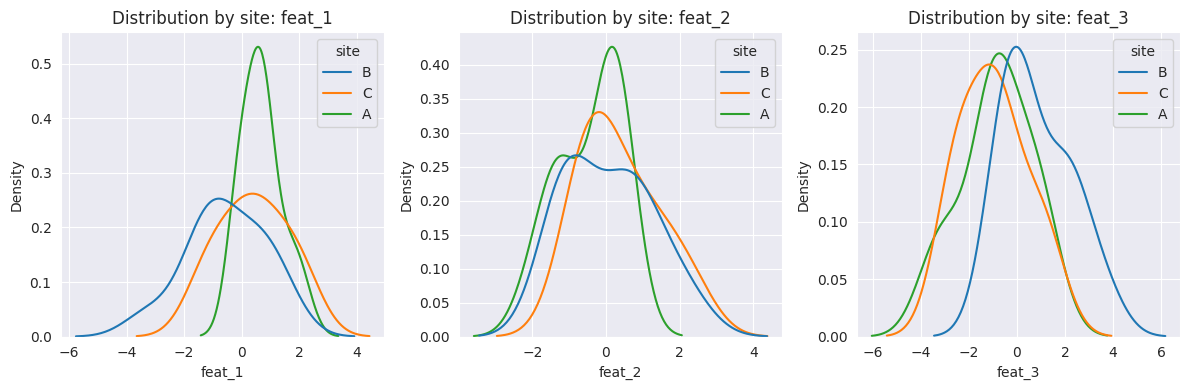

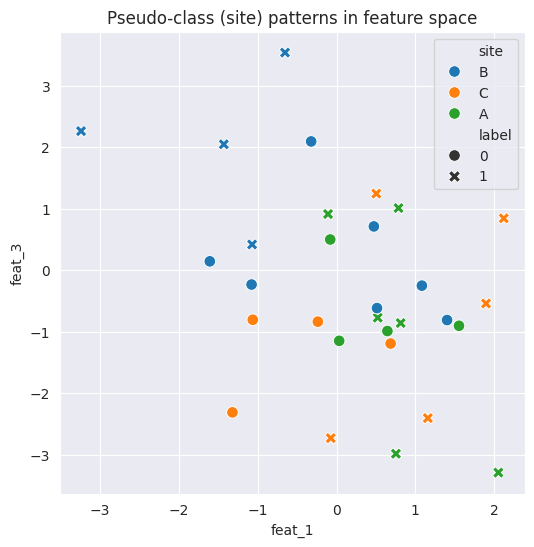

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
for i, col in enumerate(["feat_1", "feat_2", "feat_3"], 1):
    plt.subplot(1, 3, i)
    sns.kdeplot(data=df, x=col, hue="site", common_norm=False)
    plt.title(f"Distribution by site: {col}")
plt.tight_layout()
plt.show()

# Scatter: see how site shift can appear as separability unrelated to label
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x="feat_1", y="feat_3", hue="site", style="label", s=70)
plt.title("Pseudo-class (site) patterns in feature space")
plt.show()

### Quantify spurious signal: predict site from features

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_features = df[feature_names].values
y_site = df["site"].values

X_tr, X_te, y_tr, y_te = train_test_split(X_features, y_site, test_size=0.3, random_state=0, stratify=y_site)

clf_site = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
clf_site.fit(X_tr, y_tr)
pred_site = clf_site.predict(X_te)

print("Predicting pseudo-class (site) from features:")
print("Accuracy:", accuracy_score(y_te, pred_site))
print(classification_report(y_te, pred_site))

Predicting pseudo-class (site) from features:
Accuracy: 0.4444444444444444
              precision    recall  f1-score   support

           A       0.40      0.67      0.50         3
           B       0.50      0.33      0.40         3
           C       0.50      0.33      0.40         3

    accuracy                           0.44         9
   macro avg       0.47      0.44      0.43         9
weighted avg       0.47      0.44      0.43         9



### Show metric inflation risk: label prediction with Random CV vs Group-aware CV

In [12]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GroupKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier

X_features = df[feature_names].values
y_label = df["label"].values
groups = df["site"].values  # pseudo-class to group by

rf = RandomForestClassifier(n_estimators=200, random_state=0)

# Random CV (leakage risk: train and test may contain the same site)
cv_random = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores_random = cross_val_score(rf, X_features, y_label, cv=cv_random, scoring="accuracy")

# Group-aware CV (site-blocked: no leakage across folds)
cv_group = GroupKFold(n_splits=3)
scores_group = cross_val_score(rf, X_features, y_label, cv=cv_group, groups=groups, scoring="accuracy")

print("Label prediction accuracy:")
print("  Random CV   (leakage risk):", scores_random.mean().round(3), scores_random)
print("  GroupKFold  (site-blocked):", scores_group.mean().round(3), scores_group)


Label prediction accuracy:
  Random CV   (leakage risk): 0.833 [1.         0.66666667 0.66666667 0.66666667 1.         1.
 0.66666667 1.         1.         0.66666667]
  GroupKFold  (site-blocked): 0.697 [0.63636364 0.9        0.55555556]


### Interpretation:

- If Random CV ≫ GroupKFold, your model likely exploits site artifacts.
- Group-aware CV is the safer estimate when pseudo-classes exist.

> **Tip for detection in real projects**
> - Plot PCA/t-SNE/UMAP colored by subgroup; look for separation by pseudo-class.
> - Cross-tab subgroup vs. label; test independence (e.g., Fisher’s exact, Cramér’s V).
> - Evaluate metrics **within** each subgroup; large gaps suggest shortcut learning.

### Mini-Exercises: Understanding Pseudo-classes

Now that we have created a pseudo-class (`site`) and seen how it can
influence features, try the following guided experiments:

1. **Vary the site effect (shift magnitude)**
   - Go to the `site_shifts` dictionary at the beginning and increase or decrease the
     numeric shifts (e.g., from +0.6 to +2.0).
   - **Observation goal:** How does the **predictability of site** change?
     Do features from different sites cluster more strongly?
   - **Why this matters:** Stronger site effects make pseudo-classes
     easier for models to detect, increasing the risk of shortcut learning.

---

2. **Introduce confounding between site and label**
   - Modify the code so that, for example, site B has more patients with
     `label=1` than sites A or C.
   - **Observation goal:** Compare model performance with
     **Random CV** vs. **GroupKFold**.
   - **Why this matters:** If a pseudo-class correlates with the label,
     Random CV will produce overly optimistic results, while
     Group-aware CV reveals the true difficulty.

---

3. **Identify which features encode the pseudo-class most strongly**
   - Train a Random Forest (`rf`) to predict `site`.
   - Inspect `rf.feature_importances_`.
   - **Observation goal:** Which features carry the most site signal?
   - **Why this matters:** In real biomedical datasets, identifying
     features dominated by technical artifacts can help decide whether to
     remove or adjust them.

---

> ✨ **Takeaway:**
> These exercises show that pseudo-classes can create patterns that models
> eagerly exploit, even when they are **irrelevant to the biological outcome**.
> Detecting and handling pseudo-classes is essential for building
> robust and trustworthy models.
